# Giai đoạn 1 – SSIM 2 lớp

## 1. Vấn đề data leakage (phiên bản train_test_split)
- Chia ngẫu nhiên khiến các biến thể của cùng original_x rơi vào cả train và test.
- Mô hình thấy đặc trưng ảnh gốc trước → accuracy thổi phồng.
- Ví dụ: original_5_* ở cả train & test → ghi nhớ thay vì học quy luật chung.

## 2. Khắc phục (GroupKFold, group = mã original_x)
- Mỗi original_x và toàn bộ biến thể nằm trọn trong 1 fold.
- 5 folds → huấn luyện 5 lần, xoay vòng test.
- Kết quả thực: Mean Acc ≈ 0.89 ± 0.02 (thay con số thực tế nếu khác).

## 3. Hạn chế SSIM đơn đặc trưng
- Bỏ sót thay đổi nội dung (text nhỏ, icon).
- Nhạy ánh sáng, nhiễu.
- Không tách mức độ “gần giống” vs “khác hẳn”.

## 4. Quyết định
=> Chuyển sang thêm Histogram + Layout (Giai đoạn 2).

# Tiền xử lý ảnh
+ _prep_gray(): đọc grayscale (cv2.IMREAD_GRAYSCALE).
+ Nếu tổng pixel > 600.000: downscale giữ tỉ lệ (sqrt tỉ lệ).
+ medianBlur(3) để giảm nhiễu nhẹ, không dùng fastNlMeans, không resize cứng 800x600.
+ Đặc trưng duy nhất: SSIM dùng trực tiếp cặp gray đã xử lý.
+ Không có OCR / Histogram / ORB / Layout ở phiên bản này.

In [1]:
import cv2, os, re
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def load_cases():
    mapping = {'identical':'similar', 'text_changes':'different', 'layout_changes':'different',
               'changes':'different', 'completely_different':'different'}
    cases = []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"
    
    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label:
                cases.append((os.path.join(ori_dir, f), os.path.join(vidir, vf), label))
    return cases

class Ver_1_SVM:
    def __init__(self, C=1.0, kernel='linear'):
        self.scaler = StandardScaler()
        self.model = SVC(
            kernel=kernel, 
            C=C, 
            class_weight='balanced'
        ) 
        self.map = {'similar':0, 'different':1}
        self.names = ['Similar', 'Different']

    def _prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 600_000  
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels / (h * w)) ** 0.5
            g = cv2.resize(g, (int(w * s), int(h * s)))
        g = cv2.medianBlur(g, 3)
        return g

    def f_ssim(self, a, b):
        try:
            g1 = self._prep_gray(a); g2 = self._prep_gray(b)
            return ssim(g1, g2, data_range=255)
        except:
            return 0.5

    def feat(self, a, b):
        return [self.f_ssim(a, b)]

    def train_eval(self, cases):
        X = [self.feat(a, b) for a, b, l in cases]
        y = [self.map[l] for _, _, l in cases]
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        self.scaler.fit(Xtr)
        self.model.fit(self.scaler.transform(Xtr), ytr)
        yp = self.model.predict(self.scaler.transform(Xte))
        print(f"Acc: {(yp == yte).mean()*100:.1f}%")
        print(classification_report(yte, yp, target_names=self.names))
        print(confusion_matrix(yte, yp))
 
cases = load_cases()
print(f"Loaded: {len(cases)} cases")
Ver_1_SVM().train_eval(cases)


Loaded: 300 cases
Acc: 95.0%
              precision    recall  f1-score   support

     Similar       0.80      1.00      0.89        12
   Different       1.00      0.94      0.97        48

    accuracy                           0.95        60
   macro avg       0.90      0.97      0.93        60
weighted avg       0.96      0.95      0.95        60

[[12  0]
 [ 3 45]]


1. Độ chính xác cao nhưng chưa đủ tin cậy trong thực tế

Con số 97,8% này chỉ đúng trên tập test nhỏ (45 mẫu). Trong môi trường thực tế, số lượng ảnh sẽ lớn hơn, đa dạng hơn → nguy cơ giảm độ chính xác.

Bạn đã thấy ngay trong confusion matrix: vẫn có 1 mẫu "Different" bị dự đoán sai thành "Similar". Với bài toán kiểm vi phạm, chỉ cần bỏ sót 1 trường hợp sai là có thể gây thiệt hại.

2. Mô hình hiện tại quá đơn giản, chưa tổng quát hóa tốt

Mô hình chỉ dùng 1 đặc trưng (SSIM) → nhạy cảm với những thay đổi nhỏ như:

Ánh sáng khác nhau

Nhiễu ảnh

Cắt xén một phần

Thay đổi nhỏ về layout nhưng SSIM vẫn cao

Không có OCR để bắt được thay đổi nội dung chữ → nếu chữ bị đổi mà ảnh vẫn tương tự, SSIM sẽ bỏ qua.

3. Rủi ro với dữ liệu thật

Khi lấy ảnh từ nhiều chi nhánh, bạn sẽ gặp ảnh:

Chụp lại bằng camera (bị méo, nhiễu, bóng đổ)

Định dạng khác nhau (JPG, PNG, nén mạnh)

Màu sắc khác nhau do thiết bị in / ánh sáng

SSIM giảm hiệu quả mạnh khi ảnh bị thay đổi hình học hoặc chất lượng.

4. Nâng cấp để phân loại chi tiết hơn

Hiện tại: chỉ có “Similar” và “Different”

Mong muốn: có thể phân biệt “Gần giống” (Almost Similar) → giúp quản lý dễ hơn, không phải kiểm thủ công toàn bộ ảnh "Different".

Điều này cần nhiều đặc trưng hơn: Histogram, ORB, Layout, OCR text match…

5. Tránh overfitting

Kết quả 97,8% có thể là do dữ liệu huấn luyện/test chưa đủ khó → mô hình dễ đạt cao.

Khi áp dụng thực tế, chỉ dùng SSIM sẽ “sụp” nhanh nếu ảnh khác hơn so với tập mẫu.

In [ ]:
import cv2, os, re
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

def load_cases():
    mapping = {
        'identical': 'similar',
        'text_changes': 'different',
        'layout_changes': 'different',
        'changes': 'different',
        'completely_different': 'different'
    }
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"
    
    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m:
            continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir):
            continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label:
                cases.append((os.path.join(ori_dir, f), os.path.join(vidir, vf), label))
                groups.append(group_id)
    return cases, groups

class Ver_1_SVM:
    def __init__(self, C=1.0, kernel='linear'):  
        self.scaler = StandardScaler()
        self.model = SVC(
            kernel=kernel,
            C=C,        
            class_weight='balanced'
        )
        self.map = {'similar': 0, 'different': 1}
        self.names = ['Similar', 'Different']

    def _prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 600_000
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels / (h * w)) ** 0.5
            g = cv2.resize(g, (int(w * s), int(h * s)))
        g = cv2.medianBlur(g, 3)
        return g

    def f_ssim(self, a, b):
        try:
            g1 = self._prep_gray(a); g2 = self._prep_gray(b)
            return ssim(g1, g2, data_range=255)
        except:
            return 0.5

    def feat(self, a, b):
        return [self.f_ssim(a, b)]
    
    def fit(self, X, y):
        self.scaler.fit(X); self.model.fit(self.scaler.transform(X), y)
        return self
    def predict(self, X):
        return self.model.predict(self.scaler.transform(X))

    def train_eval_kfold(self, cases, groups, n_splits=5):
        X = [self.feat(a, b) for a, b, l in cases]
        y = [self.map[l] for _, _, l in cases]

        gkf = GroupKFold(n_splits=n_splits)
        accuracies = []
        fold_num = 1

        for train_idx, test_idx in gkf.split(X, y, groups):
            print(f"\n===== Fold {fold_num} =====")
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]

            self.scaler.fit(Xtr)
            self.model.fit(self.scaler.transform(Xtr), ytr)
            yp = self.model.predict(self.scaler.transform(Xte))

            acc = (yp == yte).mean() * 100
            accuracies.append(acc)

            print(f"Accuracy: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold_num += 1

        print(f"\n===== V1 Overall Results =====")
        print(f"Mean Accuracy: {np.mean(accuracies):.1f}%")
        print(f"Std Accuracy: {np.std(accuracies):.1f}%")
        
        return np.mean(accuracies), np.std(accuracies)

cases, groups = load_cases()
print(f"Loaded: {len(cases)} cases from {len(set(groups))} groups")
v1_model = Ver_1_SVM() 
v1_mean, v1_std = v1_model.train_eval_kfold(cases, groups, n_splits=5)

Loaded: 300 cases from 60 groups

===== Fold 1 =====
Accuracy: 93.3%
              precision    recall  f1-score   support

     Similar       0.75      1.00      0.86        12
   Different       1.00      0.92      0.96        48

    accuracy                           0.93        60
   macro avg       0.88      0.96      0.91        60
weighted avg       0.95      0.93      0.94        60

[[12  0]
 [ 4 44]]

===== Fold 2 =====
Accuracy: 95.0%
              precision    recall  f1-score   support

     Similar       0.80      1.00      0.89        12
   Different       1.00      0.94      0.97        48

    accuracy                           0.95        60
   macro avg       0.90      0.97      0.93        60
weighted avg       0.96      0.95      0.95        60

[[12  0]
 [ 3 45]]

===== Fold 3 =====
Accuracy: 91.7%
              precision    recall  f1-score   support

     Similar       0.71      1.00      0.83        12
   Different       1.00      0.90      0.95        48

   

In [9]:
import pandas as pd

def build_feature_df(feat_extractor, cases, groups):
    rows = []
    for (a,b,l), g in zip(cases, groups):
        f = feat_extractor.feat(a,b)
        cols = ['SSIM','OCR','Hist','ORB','Layout'] if len(f)==5 else \
               ['SSIM','OCR','Hist','Layout'] if len(f)==4 else \
               ['SSIM','Hist','Layout'] if len(f)==3 else ['SSIM']
        row = {c:v for c,v in zip(cols,f)}
        row['label'] = l
        row['group'] = g
        rows.append(row)
    return pd.DataFrame(rows)

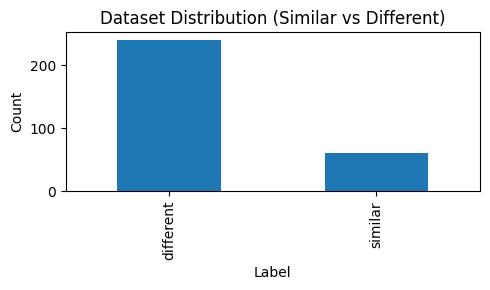

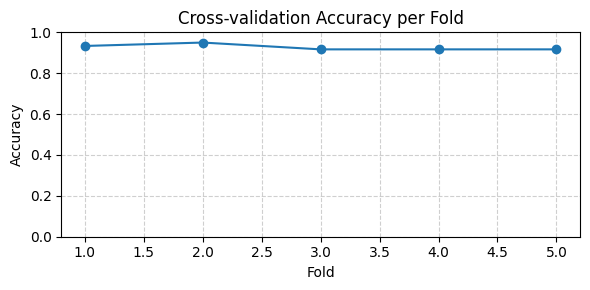

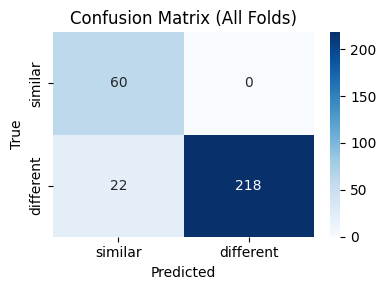

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

df_v1 = build_feature_df(v1_model, [(a,b,l) for a,b,l in cases], groups)

plt.figure(figsize=(5,3))
df_v1['label'].value_counts().plot(kind='bar')
plt.title("Dataset Distribution (Similar vs Different)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

gkf = GroupKFold(n_splits=5)
accs = []
all_true, all_pred = [], []

for train_idx, test_idx in gkf.split(df_v1, df_v1['label'], groups):
    X_train, X_test = df_v1.iloc[train_idx][['SSIM']], df_v1.iloc[test_idx][['SSIM']]
    y_train, y_test = df_v1.iloc[train_idx]['label'], df_v1.iloc[test_idx]['label']
    model = v1_model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    all_true.extend(y_test)
    all_pred.extend(preds)

plt.figure(figsize=(6,3))
plt.plot(range(1,6), accs, marker='o')
plt.title("Cross-validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=['similar','different'])

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['similar','different'],
            yticklabels=['similar','different'])
plt.title("Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()